In [2]:
import numpy as np
import pandas as pd
import os
import math
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, MaxPooling1D, MultiHeadAttention, BatchNormalization, TimeDistributed, Layer, GlobalAveragePooling1D, Multiply, Reshape, Flatten
from keras.regularizers import L2
from keras.callbacks import TensorBoard, EarlyStopping
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# dirs
DATA_DIR = "./load.csv"

In [4]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [5]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [6]:
# Define a function to generate a list of timestamps every 2 hours within the dataset's range
def generate_timestamps(data) -> pd.DatetimeIndex:
    start = data['Timestamp'].min() + DateOffset(days=3)
    end = data['Timestamp'].max() - DateOffset(hours=2, minutes=30)
    timestamps = pd.date_range(start=start, end=end, freq='15min')
    return timestamps


In [7]:
timestamps = generate_timestamps(data)
print(timestamps.shape)

(34742,)


In [8]:
def generate_sets_for_all_timestamps(timestamps, data):
    training_sets = []
    change_rate_sets = []
    target_sets = []
    training_sets_time = []
    target_sets_time = []

    for timestamp in timestamps:
        # Calculate the range for the current period's data
        start_time_current = timestamp - DateOffset(days=2, hours=23, minutes=45)
        end_time_current = timestamp

        # Calculate the equivalent timestamp for last week
        # timestamp_last_week = timestamp - DateOffset(days=7)
        # start_time_last_week = timestamp_last_week - DateOffset(days=0, hours=23, minutes=45)
        # end_time_last_week = timestamp_last_week

        # Calculate the target range (the next 10 steps after the current timestamp)
        target_start_time = timestamp + DateOffset(minutes=15)
        target_end_time = timestamp + DateOffset(hours=2, minutes=30) 

        # Filter the data for training and target sets
        current_data = data[(data['Timestamp'] >= start_time_current) & (data['Timestamp'] <= end_time_current)]
        # last_week_data = data[(data['Timestamp'] >= start_time_last_week) & (data['Timestamp'] <= end_time_last_week)]
        target_data = data[(data['Timestamp'] >= target_start_time) & (data['Timestamp'] <= target_end_time)]

        # Combine current and last week data for the training set
        training_data = pd.concat([current_data]).reset_index(drop=True)
        
        # Save the training and target sets
        if not training_data.empty and not target_data.empty:
            training_sets.append(training_data['Load'])
            target_sets.append(target_data['Load'])
            training_sets_time.append(list(training_data['Timestamp']))
            target_sets_time.append(list(target_data['Timestamp']))

    training_sets = np.array(training_sets)
    target_sets = np.array(target_sets)
    training_sets_time = np.array(training_sets_time)
    target_sets_time = np.array(target_sets_time)

    return training_sets, target_sets, training_sets_time, target_sets_time


In [9]:
# Generate training and target sets for all the timestamps
training_sets, target_sets, training_sets_time, target_sets_time = generate_sets_for_all_timestamps(timestamps, data)

In [10]:
MONTH_TIME_STEP = math.floor(timestamps.shape[0] / 24)
X_test = []
y_test = []
X_test_time = []
y_test_time = []
minList = []
maxList = []
for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test.append(training_sets[start:end])
    y_test.append(target_sets[start:end])
    X_test_time.append(training_sets_time[start:end])
    y_test_time.append(target_sets_time[start:end])
    training_sets = np.concatenate([training_sets[:start], training_sets[end:]])
    target_sets = np.concatenate([target_sets[:start], target_sets[end:]])
    training_sets_time = np.concatenate([training_sets_time[:start], training_sets_time[end:]])
    target_sets_time = np.concatenate([target_sets_time[:start], target_sets_time[end:]])


In [11]:
X_test = np.concatenate([i for i in X_test])
y_test = np.concatenate([i for i in y_test])
X_test_time = np.concatenate([i for i in X_test_time])
y_test_time = np.concatenate([i for i in y_test_time])

In [12]:
X_train = training_sets.reshape(training_sets.shape[0], training_sets.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = target_sets
X_train_time = training_sets_time
y_train_time = target_sets_time


In [13]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)


(30134, 288, 1)
(4608, 288, 1)
(30134, 10)
(4608, 10)


In [14]:
class ECALayer(Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        self.t = int(abs((tf.math.log(float(input_shape[-1])) / tf.math.log(2.0) + self.b) / self.gamma))
        self.conv = Conv1D(filters=1, kernel_size=self.t, padding='same', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, inputs):
        x = GlobalAveragePooling1D()(inputs)
        x = Reshape((1, -1))(x)
        x = self.conv(x)
        x = tf.sigmoid(x)
        x = tf.squeeze(x, axis=1)
        return Multiply()([inputs, x])

    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({
            'gamma': self.gamma,
            'b': self.b
        })
        return config

In [18]:
def create_model(input_shape, num_outputs):
    inputs = Input(shape=input_shape)

    # 1D CNN for temporal feature extraction
    x = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, activation='tanh', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=5)(x)
    
    attention_output = MultiHeadAttention(num_heads=3, key_dim=96)(x, x, x)

    x = Multiply()([x, attention_output])

    # BiLSTM layer for understanding the temporal dependencies
    x = Bidirectional(LSTM(100, return_sequences=False))(x)
    # x = Bidirectional(LSTM(50, return_sequences=False))(x)
    
    # A Dense layer for output
    dense1 = Dense(32, activation="linear")(x)
    outputs = Dense(num_outputs, activation='linear')(dense1)  # For regression output

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
model = create_model(input_shape=X_train.shape[1:], num_outputs=10)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 288, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 288, 32)              128       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 288, 32)              128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 288, 64)              6208      ['batch_normalization[0]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/120
314/314 [==============================] - 34s 102ms/step - loss: 0.0090
Epoch 2/120
314/314 [==============================] - 32s 101ms/step - loss: 0.0052
Epoch 3/120
314/314 [==============================] - 32s 102ms/step - loss: 0.0047
Epoch 4/120
314/314 [==============================] - 32s 103ms/step - loss: 0.0045
Epoch 5/120
314/314 [==============================] - 33s 104ms/step - loss: 0.0043
Epoch 6/120
314/314 [==============================] - 33s 104ms/step - loss: 0.0041
Epoch 7/120
314/314 [==============================] - 32s 102ms/step - loss: 0.0039
Epoch 8/120
314/314 [==============================] - 32s 103ms/step - loss: 0.0038
Epoch 9/120
314/314 [==============================] - 33s 106ms/step - loss: 0.0036
Epoch 10/120
314/314 [==============================] - 32s 101ms/step - loss: 0.0035
Epoch 11/120
314/314 [==============================] - 32s

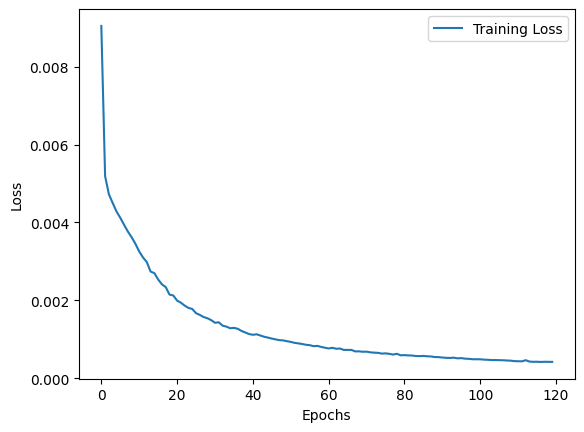

In [20]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard

tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
# early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10, min_delta=5e-5)

with tf.device("/GPU:0"):
    history = model.fit(
        X_train,
        y_train,
        verbose=1,
        epochs=120,
        batch_size=96,
        callbacks=[tensorboard_callback]
    )
 
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

# without L2, epochs: 100
# --------------------------------------------------------------------------------------
# mse: 0.0037
# rmse: 0.0606
# mae: 0.0395
# r2: 0.8492
# --------------------------------------------------------------------------------------

# with L2, epochs: 96
# --------------------------------------------------------------------------------------
# mse: 0.0048
# rmse: 0.0694
# mae: 0.0460
# r2: 0.8022
# --------------------------------------------------------------------------------------



144/144 [==============================] - 4s 25ms/step
--------------------------------------------------------------------------------------
mse: 0.0047
rmse: 0.0683
mae: 0.0444
r2: 0.8085
--------------------------------------------------------------------------------------


In [22]:
# model.save("CNN_attention_BiLSTM.keras")

In [23]:
TEST_PLOT_DIR = "./test_plots/CNN_Attention_BiLSTM/"

In [24]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")

In [26]:
pred_data = scaler.inverse_transform(y_pred)
actual_data = scaler.inverse_transform(y_test)
previous_data = scaler.inverse_transform(X_test[:, :, 0])
for i in range(actual_data.shape[0]):
    plt.figure(figsize=(12, 6))
    X1 = np.concatenate((X_test_time[i][-30:], y_test_time[i]))
    y1 = np.concatenate((previous_data[i][-30:], actual_data[i]))
    X2 = y_test_time[i]
    y_p = pred_data[i]
    y_a = actual_data[i]
    Xh = np.full(100, X1[len(X1)-10])
    yh = np.arange(0, 100, 1)
    plt.title(f"Time Series {i+1} prediction")
    plt.plot(X1, y1, '--', color='#98afc7')
    plt.plot(X2, y_p, label='Predict')
    plt.plot(X2, y_a, label='Actual')
    plt.scatter(X2, y_p)
    plt.scatter(X2, y_a)
    plt.plot(Xh, yh, color='#4863a0', alpha=0.5)
    plt.ylim(0, 100)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(TEST_PLOT_DIR+f"Time_Series_{i+1}.png")
    plt.close()